In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = '/Users/kevindai/UCSF_Fall_2025/gwas 2/12859_2019_2897_MOESM2_ESM.xlsx'
sheet_names = ['E.coli (iJ01366)', 'B. subtilis (iYO844)', 
               'G. metallireducens (iAF987)', 'K. pneumoniae (iYL1228)', 
               'S. cerevisiae (iMM904)']

# 2. The Import Loop
for name in sheet_names:
    print(f"Processing {name}...")
    
    # --- THIS IS THE IMPORT LINE ---
    # index_col=0 sets the first column (Reaction IDs) as the index
    raw_df = pd.read_excel(file_path, index_col=0, sheet_name=name)
    
    # 3. Validation (Optional but recommended)
    # Check if the matrix is square (Rows == Columns)
    if raw_df.shape[0] != raw_df.shape[1]:
        print(f"Warning: Matrix for {name} is not square! {raw_df.shape}")

Processing E.coli (iJ01366)...
Processing B. subtilis (iYO844)...
Processing G. metallireducens (iAF987)...
Processing K. pneumoniae (iYL1228)...
Processing S. cerevisiae (iMM904)...


In [7]:
all_species_data = []
g = nx.from_pandas_adjacency(raw_df,create_using=nx.DiGraph)

def calculate_bridging_centrality(g):
    # 1. Calculate Betweenness
    betweenness = nx.betweenness_centrality(g, normalized=True)
    
    bridging_coefficient = {}
    total_degrees = dict(g.degree()) 
    
    # 2. Calculate Bridging Coefficient
    for node in g.nodes():
        d_total_i = total_degrees[node]
        
        predecessors = list(g.predecessors(node))
        successors = list(g.successors(node))
        
        if len(predecessors) == 0 or len(successors) == 0:
            bridging_coefficient[node] = 0.0
            continue
        
        # Combine neighbors 
        all_neighbors = list(set(predecessors + successors))
        
        if d_total_i == 0 or not all_neighbors:
            bridging_coefficient[node] = 0.0
            continue
        
        sum_inv_deg_neighbor = 0 
        for neighbor in all_neighbors:
            d_total_neighbor = total_degrees[neighbor]
            if d_total_neighbor > 0:
                sum_inv_deg_neighbor += (1 / d_total_neighbor)
        
        if sum_inv_deg_neighbor == 0:
            bridging_coefficient[node] = 0.0
        else: 
            numerator = 1 / d_total_i
            bridging_coefficient[node] = numerator / sum_inv_deg_neighbor

    # 3. Calculate Final BRC
    bridging_centrality = {}
    for node in g.nodes():
        bridging_centrality[node] = betweenness[node] * bridging_coefficient.get(node, 0.0)
    
    return bridging_centrality

In [9]:
for name in sheet_names:
    print(f"Processing {name}...")
    raw_df = pd.read_excel(file_path, index_col=0, sheet_name=name)
    G = nx.from_pandas_adjacency(raw_df, create_using=nx.DiGraph)
    brc_results = calculate_bridging_centrality(G)
    # Store Results
    for node, score in brc_results.items():
        if score > 0: # Filter zeros
            all_species_data.append({
                'Species': name,
                'Reaction_ID': node,
                'BRC': score
            })

# 3. CREATE FINAL DATAFRAME
final_df = pd.DataFrame(all_species_data)
print(final_df.head())

Processing E.coli (iJ01366)...
Processing B. subtilis (iYO844)...
Processing G. metallireducens (iAF987)...
Processing K. pneumoniae (iYL1228)...
Processing S. cerevisiae (iMM904)...
            Species   Reaction_ID       BRC
0  E.coli (iJ01366)       APH120   0.000005
1  E.coli (iJ01366)   FA120ACPHi   0.000100
2  E.coli (iJ01366)    FACOAE120   0.000127
3  E.coli (iJ01366)   2AGPGAT120   0.000143
4  E.coli (iJ01366)       AACPS7   0.000033


In [13]:
final_df

,Species,Reaction_ID,BRC
0,E.coli (iJ01366),APH120,0.000005
1,E.coli (iJ01366),FA120ACPHi,0.000100
2,E.coli (iJ01366),FACOAE120,0.000127
3,E.coli (iJ01366),2AGPGAT120,0.000143
4,E.coli (iJ01366),AACPS7,0.000033
...,...,...,...
4153,S. cerevisiae (iMM904),CERS224er,0.000002
4154,S. cerevisiae (iMM904),CERS226er,0.000002
4155,S. cerevisiae (iMM904),G6PDH2er,0.000003
4156,S. cerevisiae (iMM904),SBPP1er,0.000006


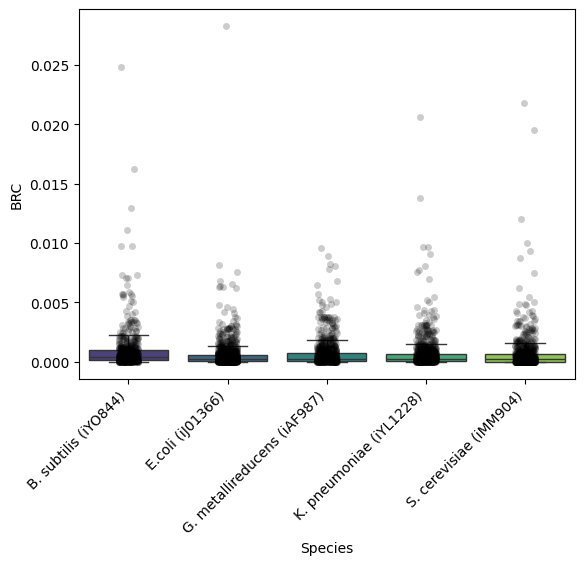

In [15]:
final_df = final_df.sort_values(by=['Species', 'BRC'], ascending=[True, False])
sns.boxplot(data = final_df, x = 'Species', y = 'BRC', hue = 'Species',showfliers=False, palette='viridis')
sns.stripplot(data=final_df, x='Species', y='BRC', color='black', alpha=0.2, size = 5, jitter=True)
plt.xticks(rotation=45, ha =
          'right')
plt.show()

In [17]:
final_df['BRC'].max()

np.float64(0.028274209122535823)

In [19]:
final_df.groupby(['Species','Reaction_ID']).value_counts()

Species                 Reaction_ID    BRC     
B. subtilis (iYO844)    2S6HCCi        0.000084    1
                        3NUCLE1        0.000327    1
                        3NUCLE2        0.000248    1
                        3NUCLE3        0.000239    1
                        3NUCLE4        0.000667    1
                                                  ..
S. cerevisiae (iMM904)  XYLK           0.000600    1
                        XYLTD_D        0.000451    1
                        YUMPS          0.000852    1
                        ZYMSTAT_SC     0.000401    1
                        ZYMSTESTH_SC   0.000045    1
Name: count, Length: 4158, dtype: int64

In [21]:
top_nodes = final_df.groupby('Species').apply(
    lambda x: x.nlargest(50, 'BRC')
).reset_index(drop=True)


/var/folders/wf/87qkv0z93v7bhv8m4dfkhp0h0000gn/T/ipykernel_90461/3715297938.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_nodes = final_df.groupby('Species').apply(


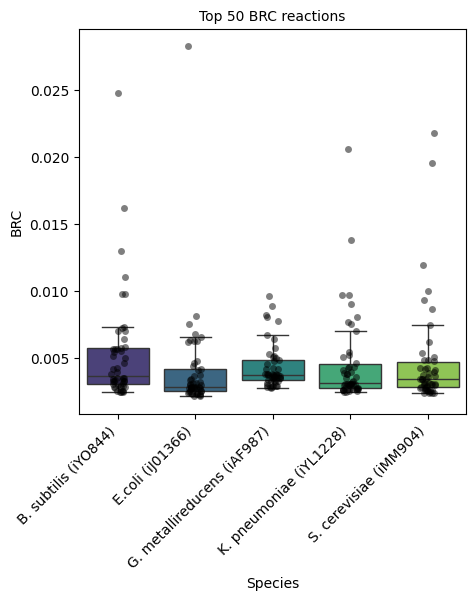

In [23]:
top_nodes = top_nodes.sort_values(by=['Species', 'BRC'], ascending=[True, False])
top_nodes['Rank'] = top_nodes.groupby('Species').cumcount() + 1


plt.figure(figsize=(5,5))
sns.boxplot(data=top_nodes, x = 'Species', y = 'BRC', hue = 'Species',showfliers=False, palette='viridis')
sns.stripplot(data=top_nodes, x='Species', y='BRC', color='black', alpha=0.5, size = 5, jitter=True)
#sns.pointplot(data=top_nodes, x='Species', y='BRC', 
#              estimator=np.max, color='red', markers='o', linestyles='--', errorbar=None, alpha = 0.3)
#sns.lineplot(data=top_nodes, x='Reaction', y='BRC', color='blue', alpha=0.5)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 50 BRC reactions', size = 10)
plt.show()

/var/folders/wf/87qkv0z93v7bhv8m4dfkhp0h0000gn/T/ipykernel_90461/3831534000.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_25_nodes = final_df.groupby('Species').apply(


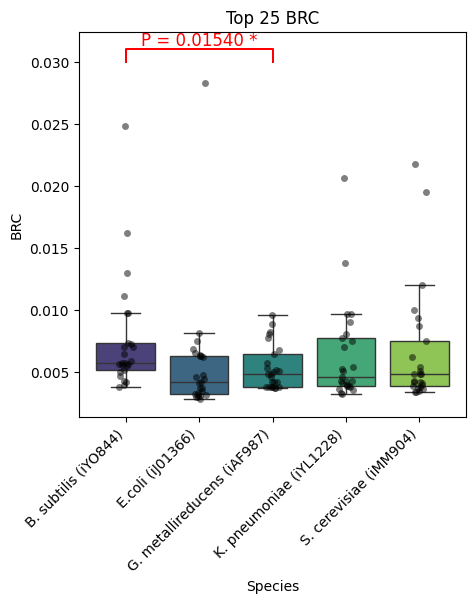

In [50]:
top_25_nodes = final_df.groupby('Species').apply(
    lambda x: x.nlargest(25, 'BRC')
).reset_index(drop=True)
top_25_nodes = top_25_nodes.sort_values(by=['Species', 'BRC'], ascending=[True, False])
top_25_nodes['Rank'] = top_25_nodes.groupby('Species').cumcount() + 1

plt.figure(figsize=(5,5))
sns.boxplot(data=top_25_nodes, x = 'Species', y = 'BRC', hue = 'Species',showfliers=False,palette='viridis')
sns.stripplot(data=top_25_nodes, x='Species', y='BRC', color='black', alpha=0.5, size = 5, jitter=True)
x1, x2 = 0, 2   
y, h = 0.030, 0.001
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.45, c='red')
plt.text((x1+x2)*.5, y+h, "P = 0.01540 *", ha='center', va='bottom', color='red', fontsize=12)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 25 BRC')
plt.show()

In [27]:
def diff_in_means(x, y):
    return np.mean(x) - np.mean(y)

In [29]:
from scipy.stats import permutation_test
from itertools import combinations
species_list = top_nodes['Species'].unique()
results = []
print(f"{'Species A':<25} | {'Species B':<25} | {'P-Value':<10} | {'Result'}")
print("-" * 80)

for s1, s2 in combinations(species_list, 2):
    group_a = top_nodes[top_nodes['Species'] == s1]['BRC'].values
    group_b = top_nodes[top_nodes['Species'] == s2]['BRC'].values
    res = permutation_test((group_a,group_b),diff_in_means,
    n_resamples=10000, alternative='two-sided')
    pvalue = res.pvalue
    sig_label = 'Significant' if pvalue < 0.05 else 'Not Significant'
    if pvalue < 0.05:
        sig_label += '(*)'
    print(f"{s1:<25} | {s2:<25} | {pvalue:.5f}    | {sig_label}")
    results.append({'Species A': s1, 'Species B':s2,'P-value':pvalue})

Species A                 | Species B                 | P-Value    | Result
--------------------------------------------------------------------------------
B. subtilis (iYO844)      | E.coli (iJ01366)          | 0.11999    | Not Significant
B. subtilis (iYO844)      | G. metallireducens (iAF987) | 0.11539    | Not Significant
B. subtilis (iYO844)      | K. pneumoniae (iYL1228)   | 0.32617    | Not Significant
B. subtilis (iYO844)      | S. cerevisiae (iMM904)    | 0.46375    | Not Significant
E.coli (iJ01366)          | G. metallireducens (iAF987) | 0.75412    | Not Significant
E.coli (iJ01366)          | K. pneumoniae (iYL1228)   | 0.47875    | Not Significant
E.coli (iJ01366)          | S. cerevisiae (iMM904)    | 0.43376    | Not Significant
G. metallireducens (iAF987) | K. pneumoniae (iYL1228)   | 0.65773    | Not Significant
G. metallireducens (iAF987) | S. cerevisiae (iMM904)    | 0.55254    | Not Significant
K. pneumoniae (iYL1228)   | S. cerevisiae (iMM904)    | 0.87951    | N

In [31]:
stats_df = pd.DataFrame(results)

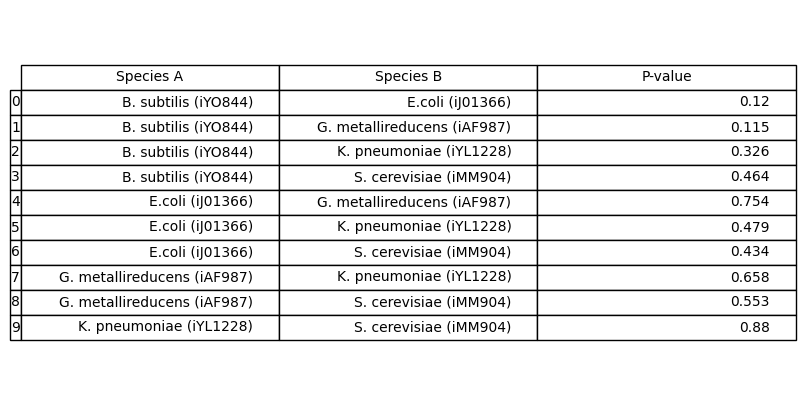

In [33]:
from tabulate import tabulate
fig, ax = plt.subplots(figsize=(10, 0.5 * len(stats_df)))
ax.axis('off')

table = ax.table(
    cellText=stats_df.round(3).values,
    colLabels=stats_df.columns,
    rowLabels=stats_df.index,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig("stats_table.png", dpi=1440, bbox_inches='tight')
#plt.close()

In [35]:
stats_df.style.format(precision=2)

,Species A,Species B,P-value
0,B. subtilis (iYO844),E.coli (iJ01366),0.12
1,B. subtilis (iYO844),G. metallireducens (iAF987),0.12
2,B. subtilis (iYO844),K. pneumoniae (iYL1228),0.33
3,B. subtilis (iYO844),S. cerevisiae (iMM904),0.46
4,E.coli (iJ01366),G. metallireducens (iAF987),0.75
5,E.coli (iJ01366),K. pneumoniae (iYL1228),0.48
6,E.coli (iJ01366),S. cerevisiae (iMM904),0.43
7,G. metallireducens (iAF987),K. pneumoniae (iYL1228),0.66
8,G. metallireducens (iAF987),S. cerevisiae (iMM904),0.55
9,K. pneumoniae (iYL1228),S. cerevisiae (iMM904),0.88


In [37]:
species_list = top_25_nodes['Species'].unique()
results = []
print(f"{'Species A':<25} | {'Species B':<25} | {'P-Value':<10} | {'Result'}")
print("-" * 80)

for s1, s2 in combinations(species_list, 2):
    group_a = top_25_nodes[top_25_nodes['Species'] == s1]['BRC'].values
    group_b = top_25_nodes[top_25_nodes['Species'] == s2]['BRC'].values
    res = permutation_test((group_a,group_b),diff_in_means,
    n_resamples=10000, alternative='two-sided')
    pvalue = res.pvalue
    sig_label = 'Significant' if pvalue < 0.05 else 'Not Significant'
    if pvalue < 0.05:
        sig_label += '(*)'
    print(f"{s1:<25} | {s2:<25} | {pvalue:.5f}    | {sig_label}")
    results.append({'Species A': s1, 'Species B':s2,'P-value':pvalue})

Species A                 | Species B                 | P-Value    | Result
--------------------------------------------------------------------------------
B. subtilis (iYO844)      | E.coli (iJ01366)          | 0.15018    | Not Significant
B. subtilis (iYO844)      | G. metallireducens (iAF987) | 0.01540    | Significant(*)
B. subtilis (iYO844)      | K. pneumoniae (iYL1228)   | 0.33537    | Not Significant
B. subtilis (iYO844)      | S. cerevisiae (iMM904)    | 0.48715    | Not Significant
E.coli (iJ01366)          | G. metallireducens (iAF987) | 0.96810    | Not Significant
E.coli (iJ01366)          | K. pneumoniae (iYL1228)   | 0.56274    | Not Significant
E.coli (iJ01366)          | S. cerevisiae (iMM904)    | 0.48175    | Not Significant
G. metallireducens (iAF987) | K. pneumoniae (iYL1228)   | 0.27817    | Not Significant
G. metallireducens (iAF987) | S. cerevisiae (iMM904)    | 0.25917    | Not Significant
K. pneumoniae (iYL1228)   | S. cerevisiae (iMM904)    | 0.84992    | No

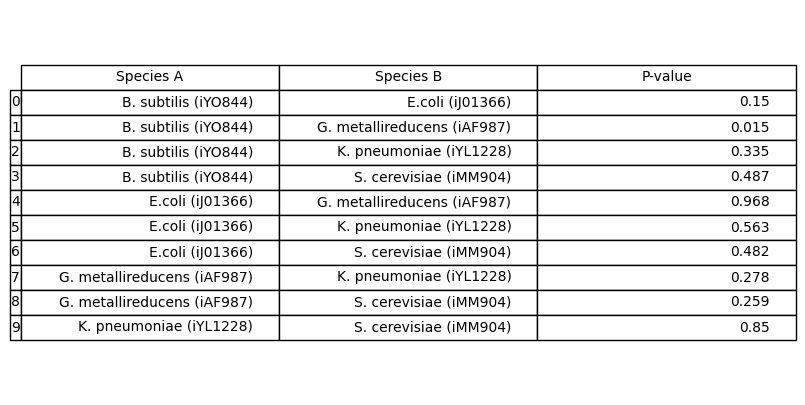

In [39]:
stats_df_25 = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 0.5 * len(stats_df)))
ax.axis('off')

table = ax.table(
    cellText=stats_df_25.round(3).values,
    colLabels=stats_df_25.columns,
    rowLabels=stats_df_25.index,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig("stats_table.png", dpi=1440, bbox_inches='tight')
#plt.close()

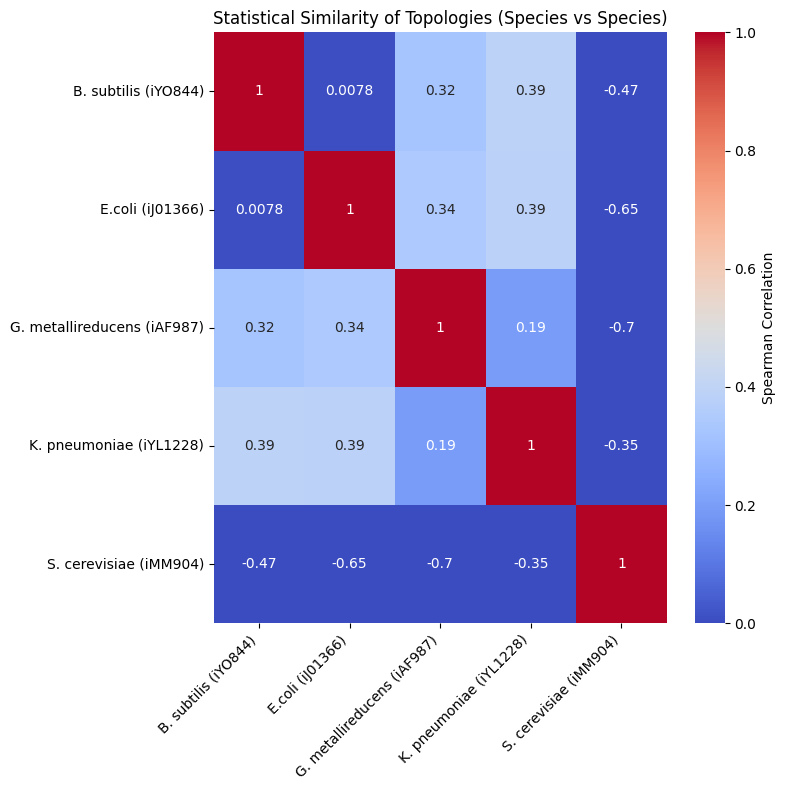

In [82]:
top_union = top_25_nodes['Reaction_ID'].unique()
vip_data = final_df[final_df['Reaction_ID'].isin(top_union)]
heatmap_matrix = vip_data.pivot_table(index='Reaction_ID', columns='Species', values='BRC')
corr_matrix = heatmap_matrix.corr(method='spearman')
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1,
            cbar_kws={'label': 'Spearman Correlation'})

plt.title('Statistical Similarity of Topologies (Species vs Species)')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [68]:
heatmap_matrix

Species,B. subtilis (iYO844),E.coli (iJ01366),G. metallireducens (iAF987),K. pneumoniae (iYL1228),S. cerevisiae (iMM904)
Reaction_ID,,,,,
3OAR100,NaN,0.004782,0.006427,0.005238,NaN
3OAR120,NaN,0.002826,0.003790,0.003095,NaN
3OAR141,NaN,0.002799,0.003759,0.003066,NaN
3OAR160,NaN,0.002826,0.003790,0.003095,NaN
3OAR161,NaN,0.002826,0.003790,0.003095,NaN
...,...,...,...,...,...
SULR,NaN,NaN,0.002127,0.000806,0.004856
THRD,0.009774,0.000124,NaN,0.000188,NaN
TRPO2,NaN,NaN,NaN,NaN,0.010038


<Figure size 500x500 with 0 Axes>

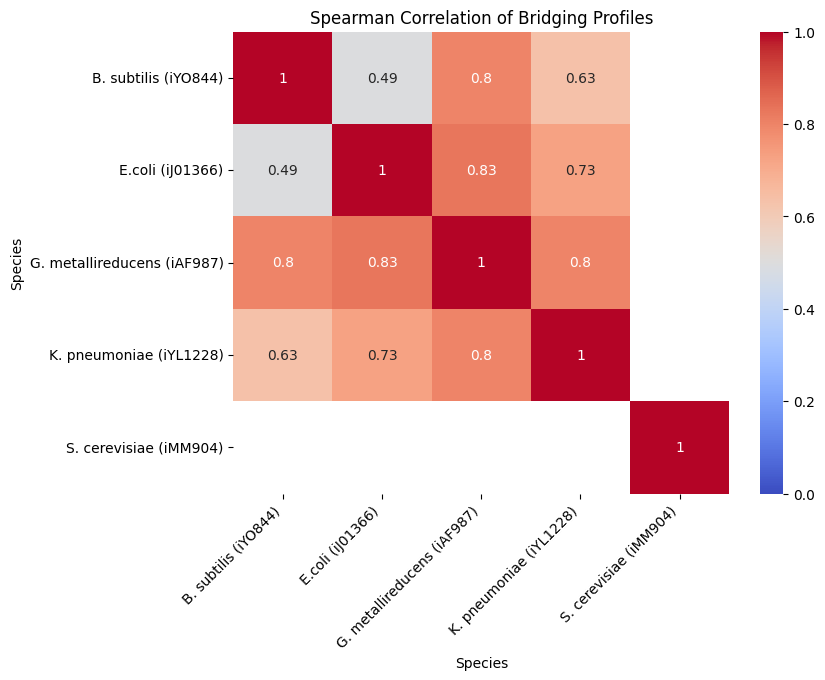

In [41]:
heatmap_matrix = top_25_nodes.pivot_table(index='Reaction_ID', columns='Species', values='BRC')
plt.figure(figsize=(5, 5))
corr_matrix = heatmap_matrix.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Spearman Correlation of Bridging Profiles')
plt.xticks(rotation=45,ha = 'right')
plt.show()